In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

In [2]:
num_epochs = 5
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

In [3]:
#model
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), # optimization
             loss='sparse_categorical_crossentropy', # loss function
             metrics=['accuracy']) # metrics / accuracy

In [5]:
# Data Preprocess

train_paths = sorted(glob('/Users/sengjeawang/Desktop/data/dataset/cifar/train/*.png'))[:100]
test_paths = sorted(glob('/Users/sengjeawang/Desktop/data/dataset/cifar/test/*.png'))[:100]

len(train_paths), len(test_paths)

(100, 100)

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [7]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)

In [8]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    image = tf.cast(image, tf.float32) / 255.
    
    label = get_label(path)
    return image, label

In [9]:
def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [12]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

In [13]:
# Training

steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,

)

/Users/sengjeawang/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
3/3 [==============================] - 1s 131ms/step - loss: 2.3460 - accuracy: 0.1029 - val_loss: 2.3367 - val_accuracy: 0.0417
Epoch 2/5
3/3 [==============================] - 0s 98ms/step - loss: 2.3049 - accuracy: 0.0938 - val_loss: 2.3137 - val_accuracy: 0.0729
Epoch 3/5
3/3 [==============================] - 0s 82ms/step - loss: 2.2676 - accuracy: 0.1324 - val_loss: 2.3065 - val_accuracy: 0.1771
Epoch 4/5
3/3 [==============================] - 0s 98ms/step - loss: 2.3420 - accuracy: 0.0735 - val_loss: 2.3181 - val_accuracy: 0.0729
Epoch 5/5
3/3 [==============================] - 0s 99ms/step - loss: 2.3008 - accuracy: 0.1029 - val_loss: 2.3361 - val_accuracy: 0.0729


In [15]:
# Predict

# 이미지를 load 직접 load 해서 넣는 방법

path = test_paths[0]
path

'/Users/sengjeawang/Desktop/data/dataset/cifar/test/0_cat.png'

In [16]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image.shape

TensorShape([32, 32, 3])

In [18]:
image = image[tf.newaxis, ...]  # batch size

In [19]:
image.shape

TensorShape([1, 32, 32, 3])

In [20]:
pred = model.predict(image)

In [21]:
pred.shape

(1, 10)

In [22]:
pred

array([[0.09360774, 0.08180645, 0.12770115, 0.09362813, 0.10488072,
        0.07301791, 0.11304475, 0.08934409, 0.13893044, 0.08403867]],
      dtype=float32)

In [23]:
np.argmax(pred)

8

In [24]:
# generator에서 데이터를 가져오는 방법

test_image, test_label = next(iter(test_dataset))

In [25]:
test_image.shape

TensorShape([32, 32, 32, 3])

In [26]:
pred = model.predict(test_image)

In [27]:
pred.shape

(32, 10)

In [28]:
pred[0]

array([0.09360772, 0.08180644, 0.12770113, 0.09362812, 0.10488072,
       0.07301791, 0.11304474, 0.08934409, 0.13893044, 0.08403865],
      dtype=float32)

In [30]:
np.argmax(pred[0])

8

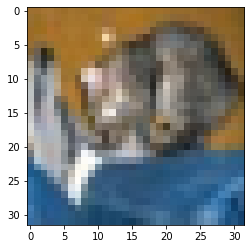

In [34]:
for image, label in test_dataset.take(1):
    plt.imshow(image[0])
    plt.show()

In [35]:
# generator에 넣는 방법

pred = model.predict_generator(test_dataset.take(2))

In [36]:
pred.shape

(64, 10)

In [38]:
image, label = next(iter(test_dataset))

In [39]:
image.shape

TensorShape([32, 32, 32, 3])

In [42]:
evals = model.evaluate(image, label)

1/1 [==============================] - 0s 23ms/step - loss: 2.3516 - accuracy: 0.1250


In [43]:
evals

[2.351576566696167, 0.125]